In [82]:
! cd ../dashboards && streamlit run st_dashboard.py


  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://192.168.1.108:8501

2024-07-24 06:23:28.620 Serialization of dataframe to Arrow table was unsuccessful due to: ("Could not convert '06c53348Lb7f6262c4261a5b7340f301f4a92' with type str: tried to convert to int64", 'Conversion failed for column userId with type object'). Applying automatic fixes for column types to make the dataframe Arrow-compatible.
^C
  Stopping...


<span style="font-family:Helvetica Light">

# JustPlay Case Study

The purpose of this case study is to conduct an exploratory analysis on the provided datasets to uncover key metrics and actionable insights related to ad performance, user installs, and revenue generation. The analysis aims to address data cleanliness, proper joins, and appropriate aggregation levels to ensure accurate and meaningful results.

Additionally, I have created a Streamlit dashboard for a more detailed exploration of all dimensions and variables. This interactive tool allows for visual data analysis, filtering by specific criteria, and gaining deeper insights into the metrics. You can access the dashboard directly via this link: [JustPlay Streamlit Dashboard](https://justplay.streamlit.app)
or by running the following command in your terminal:

```bash
cd ../dashboards && streamlit run st_dashboard.py

<span style="font-family:Helvetica Light">

***Disclaimer***: This analysis should be interpreted with caution and further analyzed with additional data points. The specific sources of the datasets used are not completely identified, and the available data represents only a single snapshot from January 1, 2024. 
Consequently, the results may not accurately capture trends and patterns over time. It is recommended to validate these findings with more comprehensive and continuous data.

<span style="font-family:Helvetica Light">

### 1. Data Overview

#### Description of the Datasets
The analysis uses three datasets:
* **Ad Spend**: Contains data on ad spend, network clicks, impressions, and installs.
* **Installs**: Each row represents an install event with user attribution information.
* **Revenue**: Each row represents a single ad impression with the generated revenue. The dataset is focused on tracking revenue events generated by user interactions with ads, which are facilitated by JustPlay as the provider. This suggests that the revenue is generated through users' engagements with ads served via JustPlay's platform.

#### Key Columns and Their Meanings

#### Ad Spend and Installs Data:
* Columns:
    * **report_day**: Date of the report
    * **country_code**: Country code
    * **os_name**: Operating system name
    * **network_clicks**: Number of clicks on ad
    * **network_impressions**: Number of impressions on ad
    * **network_installs**: Number of installs reported by channel
    * **installs**: Number of installs reported by Adjust (attribution provider)
    * **network_installs_diff**: Difference between installs reported by Adjust and channel
    * **cost**: Advertising cost
    * **channel, campaign, creative**: Campaign details
        * **channel (i.e. network)**: Ad channel name
        * **campaign**: Ad campaign name
        * **creative**: Name of the ad

#### Installs Data:
* Columns:
    * **userId**: Unique user identifier
    * **countryCode**: Country code
    * **installedAt**: Installation timestamp
    * **osVersion**: Operating system version
    * **device**: Device name
    * **limitAdTracking, adjustId, adGroupName, trackerName**: Tracking and ad group details
        * **limitAdTracking**: Flag to discover if the user limited tracking
        * **trackerName**: Adjust link token
        * **adjustId**: Unique Adjust identifier
        * **adGroupName**: Group name of the ad
    * **channel, campaign, creative**: Campaign details
        * **channel (i.e. network)**: Ad channel name (previously ad_network)
        * **campaign**: Ad campaign name
        * **creative**: Name of the ad
    * **os_name**: Operating system name
    * **googleAdId, idfa, idfv**: Advertising identifiers

#### Revenue Data:
* Columns:
    * **userId**: Unique user identifier
    * **createdAt**: Timestamp of the revenue event
    * **countryCode**: Country code
    * **platform**: Operating system name
    * **amount**: Revenue amount
    * **eventId**: Unique event identifier
    * **source**: 3rd party tool that is used to convert user's attention to money
    * **network**: Ad network name (same as channel?) Only for AppLovin 
    * **adUnitFormat**: Format of the ad unit (here encoded as adUnitFormat 1, 2, 3 or 4; normally values like banner, rewarded video, interstitials). Only for AppLovin revenue
    * **deviceId**: Unique device identifier
    * **advertisingId**: Identifier of the AppLovin MAX Ad Unit from which the revenue was generated
    * **packageName**: Game package name where the revenue was generated
    * **adUnitName**: Name of the AppLovin MAX Ad Unit from which the revenue was generated

*AppLovin is an ad network integrated with Adjust: [AppLovin Revenue Reporting API](https://developers.applovin.com/en/reporting-apis/revenue-reporting-api/)

In [1]:
import pandas as pd
import plotly.express as px
import plotly.io as pio 
import plotly.graph_objects as go
import pycountry
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

<span style="font-family:Helvetica Light">
    
#### Configuring Chart Styles
This section serves two main purposes:
- _Color Definition_:
  - Defining colors and color maps for all the charts, utilizing JustPlay's brand color palette, specifically referencing the blue shade.
- *Style Unification*:
    - Defining a function to unify the style across all charts, ensuring consistency in appearance.
</span>

In [2]:
justplay_colors = ['#356AF1', '#47B7FF', '#80DBFF']
heat_pal = px.colors.sequential.YlGn

In [84]:
def write(fig, name, facet=True, tickdefault=True):        

    fig.update_layout(
        template='plotly_white',
        font_family='Helvetica'
    )
    
    fig.update_yaxes(color='grey')
    fig.update_xaxes(color='grey')

    fig.show(renderer="jupyterlab")
    
    pio.write_image(fig, f'../images/{name}.png', format='png', scale=5)

<span style="font-family:Helvetica Light">

### 2. Exploratory Data Analysis

#### *Installs Dataset*
#### 2.1. Data Loading

In [87]:
installs = pd.read_csv('../data/raw/Installs_2024_01_01.csv')
print(installs.shape)
installs.head()

(101, 16)


,userId,countryCode,installedAt,osVersion,device,limitAdTracking,adjustId,adGroupName,trackerName,channel,campaign,creative,os_name,googleAdId,idfa,idfv
0,47123348Ld7f16c70403f8e1affdb1332931e,ca,2024-01-01 17:23:46.000000 UTC,9,galaxya50,False,EJRY87002175420325,adGroupName 1,trackerName 1,channel 1,campaign 1,creative 1,android,TLUV25481018293147,NaN,NaN
1,06c53348Lb7f6262c4261a5b7340f301f4a92,au,2024-01-01 01:22:50.000000 UTC,9,galaxytaba(2017),False,QLVO96314900235206,adGroupName 2,trackerName 2,channel 1,campaign 2,creative 1,android,VNSA39644876747171,NaN,NaN
2,e2743348L699571fa4fd9b4f7e8b3c5720df0,de,2024-01-01 03:29:45.000000 UTC,9,y5(2019),False,GAZL00570149805783,adGroupName 3,trackerName 3,channel 1,campaign 3,creative 2,android,FQUT15816053221647,NaN,NaN
3,d8923348L4d9b4e674e469b1cb7faa12869f4,us,2024-01-01 18:04:17.000000 UTC,9,galaxys8active,False,VQZE64662082917175,adGroupName 4,trackerName 4,channel 1,campaign 2,creative 3,android,WBXA01967468887151,NaN,NaN
4,4b253348L425fcba2462695f699e27870a6b5,us,2024-01-01 16:18:22.000000 UTC,9,journeylte,False,RCHZ07124631299886,adGroupName 5,trackerName 5,channel 2,campaign 4,creative 4,android,XNSG49174020190706,NaN,NaN


<span style="font-family:Helvetica Light">

#### 2.1. Data Cleaning

##### 2.2.1. Missing Values Analysis

In [88]:
# percentage of missing values in a column
installs.isnull().sum()/len(installs)*100

userId              0.000000
countryCode         0.000000
installedAt         0.000000
osVersion           0.000000
device              0.000000
limitAdTracking     0.000000
adjustId            0.000000
adGroupName         0.000000
trackerName         0.000000
channel             0.000000
campaign            0.000000
creative            0.000000
os_name             0.000000
googleAdId         58.415842
idfa               92.079208
idfv               43.564356
dtype: float64

<span style="font-family:Helvetica Light">

Since *'idfa'* is assigned by Apple for iOS devices, its high missing rate of 92.08% likely indicates that many users have restricted ad tracking. Similarly, *'googleAdId*' has a missing rate of 58.42%, and *'idfv'* has a missing rate of 43.56%. Due to these significant missing rates, advertising identifiers (i.e. googleAdId, idfa, and idfv) may not be reliable for analysis. Therefore, I have decided to drop these columns for now.

In [89]:
installs.drop(columns=['idfa', 'idfv', 'googleAdId'], inplace=True)

<span style="font-family:Helvetica Light">

##### 2.2.2. Duplicates Detection

In [90]:
# print the number of duplicate rows
print(f'Number of duplicate rows in installs: {installs.duplicated().sum()}')

Number of duplicate rows in installs: 6


In [91]:
# show duplicate rows
installs[installs.duplicated(keep=False)].sort_values('userId')

,userId,countryCode,installedAt,osVersion,device,limitAdTracking,adjustId,adGroupName,trackerName,channel,campaign,creative,os_name
77,2c013348Lfb9e1e924c0dabbc8e5a020517cc,us,2024-01-01 19:30:11.000000 UTC,16.6,ipad(9thgen),True,YGAL20682601452885,adGroupName 66,trackerName 70,channel 10,campaign 23,creative 39,ios
97,2c013348Lfb9e1e924c0dabbc8e5a020517cc,us,2024-01-01 19:30:11.000000 UTC,16.6,ipad(9thgen),True,YGAL20682601452885,adGroupName 66,trackerName 70,channel 10,campaign 23,creative 39,ios
83,43623348La15dd74d4a689e17e0ef205feaaa,us,2024-01-01 13:30:38.000000 UTC,17.3,iphone11pro,True,CORN41703339382907,adGroupName 69,trackerName 73,channel 6,campaign 24,creative 13,ios
96,43623348La15dd74d4a689e17e0ef205feaaa,us,2024-01-01 13:30:38.000000 UTC,17.3,iphone11pro,True,CORN41703339382907,adGroupName 69,trackerName 73,channel 6,campaign 24,creative 13,ios
4,4b253348L425fcba2462695f699e27870a6b5,us,2024-01-01 16:18:22.000000 UTC,9,journeylte,False,RCHZ07124631299886,adGroupName 5,trackerName 5,channel 2,campaign 4,creative 4,android
99,4b253348L425fcba2462695f699e27870a6b5,us,2024-01-01 16:18:22.000000 UTC,9,journeylte,False,RCHZ07124631299886,adGroupName 5,trackerName 5,channel 2,campaign 4,creative 4,android
16,4b333348Ld2fc847d47de8d61e84cb236e393,us,2024-01-01 12:33:36.000000 UTC,12,motogplay2023,False,GADI72009909627061,adGroupName 16,trackerName 16,channel 4,campaign 7,creative 8,android
98,4b333348Ld2fc847d47de8d61e84cb236e393,us,2024-01-01 12:33:36.000000 UTC,12,motogplay2023,False,GADI72009909627061,adGroupName 16,trackerName 16,channel 4,campaign 7,creative 8,android
40,84d63348Le24796af401dbc387832dd9678de,us,2024-01-01 08:33:35.000000 UTC,17.1.1,iphone15promax,False,QRKO19074758967073,adGroupName 35,trackerName 37,channel 4,campaign 16,creative 22,ios
42,84d63348Le24796af401dbc387832dd9678de,us,2024-01-01 08:33:35.000000 UTC,17.1.1,iphone15promax,False,QRKO19074758967073,adGroupName 35,trackerName 37,channel 4,campaign 16,creative 22,ios


In [92]:
# remove exact duplicate rows
installs.drop_duplicates(inplace=True)

<span style="font-family:Helvetica Light">

##### 2.2.3. Data Types Validation

In [93]:
installs.dtypes

userId             object
countryCode        object
installedAt        object
osVersion          object
device             object
limitAdTracking      bool
adjustId           object
adGroupName        object
trackerName        object
channel            object
campaign           object
creative           object
os_name            object
dtype: object

In [94]:
# convert 'installedAt' column to datetime
installs['installedAt'] = pd.to_datetime(installs['installedAt'])

# define categorical columns
# cat_columns = ['countryCode', 'adGroupName', 'trackerName', 'channel', 'campaign', 'creative', 'os_name']

# transform specified columns to category data type
# installs[cat_columns] = installs[cat_columns].astype('category')

<span style="font-family:Helvetica Light">

#### 2.3. Summary Statistics

In [95]:
installs.describe()

,userId,countryCode,installedAt,osVersion,device,limitAdTracking,adjustId,adGroupName,trackerName,channel,campaign,creative,os_name
count,95,95,95,95,95,95,95,95,95,95,95,95,95
unique,95,8,NaN,29,61,2,95,80,84,10,26,42,2
top,47123348Ld7f16c70403f8e1affdb1332931e,us,NaN,9,iphone13,True,EJRY87002175420325,adGroupName 57,trackerName 26,channel 9,campaign 23,creative 39,ios
freq,1,80,NaN,24,6,48,1,6,3,20,17,13,53
mean,NaN,NaN,2024-01-01 12:55:08.694736640+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,2024-01-01 00:17:25+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,2024-01-01 07:36:45+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,2024-01-01 14:04:07+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,2024-01-01 18:10:11.500000+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,2024-01-01 23:44:09+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [96]:
# extract the date from 'installedAt' column
installs['installedDate'] = installs['installedAt'].dt.date
installs.installedDate.value_counts()

installedDate
2024-01-01    95
Name: count, dtype: int64

In [97]:
# convert country codes to country names using pycountry library
installs['countryName'] = installs['countryCode'].apply(lambda x: pycountry.countries.get(alpha_2=x).name)

<span style="font-family:Helvetica Light">

#### 2.3. Distribution Plots

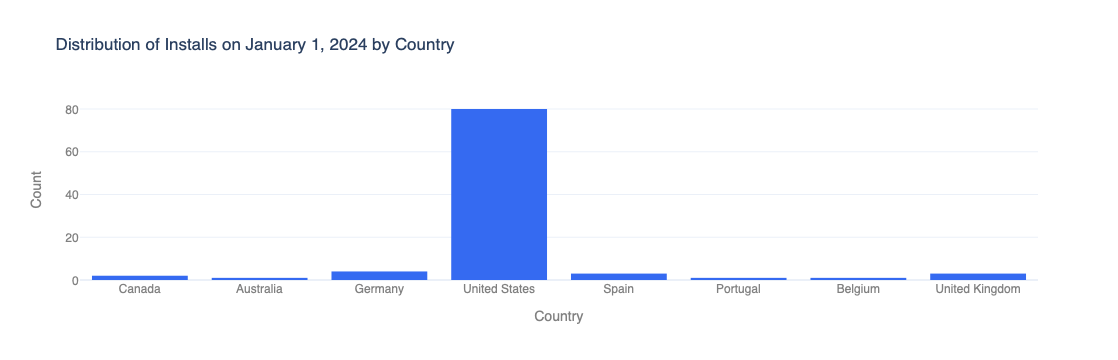

In [98]:
fig = px.histogram(
    installs, 
    x='countryName', 
    title='Distribution of Installs on January 1, 2024 by Country', 
    color_discrete_sequence=justplay_colors)

fig.update_layout(
    yaxis_title='Count',
    xaxis_title='Country'
)

write(fig, 'installs_by_country')

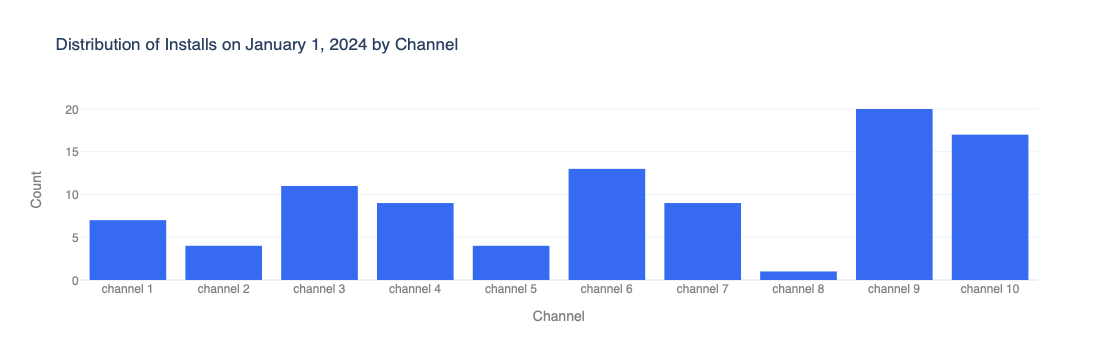

In [99]:
fig = px.histogram(
    installs, 
    x='channel', 
    title='Distribution of Installs on January 1, 2024 by Channel', 
    color_discrete_sequence=justplay_colors)

fig.update_layout(
    yaxis_title='Count',
    xaxis_title='Channel'
)

write(fig, 'installs_by_channel')

In [100]:
# this function is used to ensure that OS version numbers are correctly sorted in the plot
def version_to_tuple(version):
    return tuple(map(int, version.split('.')))

installs['osVersion_tuple'] = installs['osVersion'].apply(version_to_tuple)

installs.sort_values(by='osVersion_tuple', inplace=True)

In [101]:
installs.drop(columns='osVersion_tuple', inplace=True)

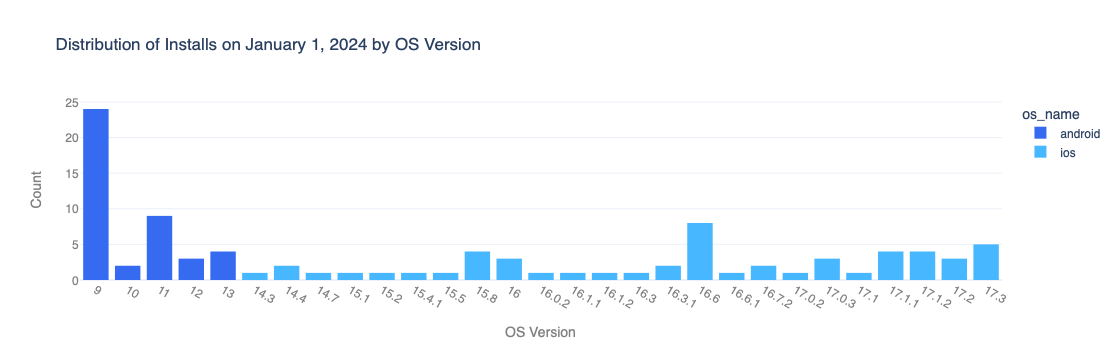

In [102]:
fig = px.histogram(
    installs, 
    x='osVersion', 
    title='Distribution of Installs on January 1, 2024 by OS Version', 
    color='os_name', 
    color_discrete_sequence=justplay_colors)

fig.update_layout(
    yaxis_title='Count',
    xaxis_title='OS Version'
)

write(fig, 'installs_by_os_version')

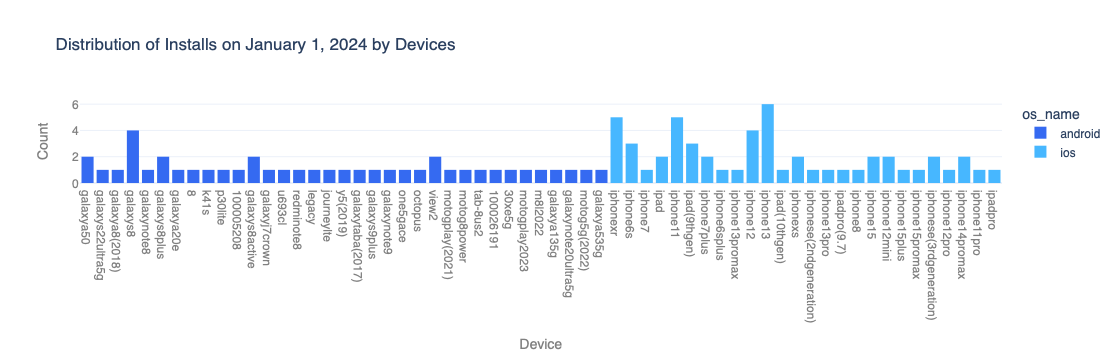

In [103]:
fig = px.histogram(
    installs, 
    x='device', 
    title='Distribution of Installs on January 1, 2024 by Devices',
    color='os_name',
    color_discrete_sequence=justplay_colors)

fig.update_layout(
    yaxis_title='Count',
    xaxis_title='Device'
)

write(fig, 'installs_by_devices')

In [104]:
installs.to_csv('../data/processed/installs.csv', index=False)

<span style="font-family:Helvetica Light">

#### *Revenue Dataset*
#### 2.1. Data Loading

In [105]:
revenue = pd.read_csv('../data/raw/revenue_2024_01_01.csv')
print(revenue.shape)
revenue.head()

(335, 13)


,userId,createdAt,countryCode,platform,amount,eventId,source,network,adUnitFormat,deviceId,advertisingId,packageName,adUnitName
0,98223348Lfc56424f4ecc8a6a51df078d3b50,2024-01-01 03:27:11.653079 UTC,ca,android,0.082510,UFOA50316346323353,source 1,network 1,adUnitFormat 1,MUKJ31662517026062,BTFB55314981998668,packageName 1,adUnitName 1
1,06c53348Lb7f6262c4261a5b7340f301f4a92,2024-01-01 04:19:04.281771 UTC,ca,android,0.000116,ACVH81800365309399,source 1,network 1,adUnitFormat 1,OPDS19296982968073,WYWS55356535259373,packageName 1,adUnitName 1
2,06c53348Lb7f6262c4261a5b7340f301f4a92,2024-01-01 04:41:18.041051 UTC,ca,android,0.000111,AJIE67942237150314,source 1,network 1,adUnitFormat 1,OPDS19296982968073,WYWS55356535259373,packageName 1,adUnitName 1
3,06c53348Lb7f6262c4261a5b7340f301f4a92,2024-01-01 05:02:39.465687 UTC,ca,android,0.000101,NMFD23525567785987,source 1,network 1,adUnitFormat 1,OPDS19296982968073,WYWS55356535259373,packageName 1,adUnitName 1
4,e2743348L699571fa4fd9b4f7e8b3c5720df0,2024-01-01 06:05:44.576467 UTC,us,android,0.004947,VTCG22147540339387,source 1,network 1,adUnitFormat 1,YBSU65690062552565,DNRA06338648505622,packageName 1,adUnitName 1


<span style="font-family:Helvetica Light">

#### 2.1. Data Cleaning

##### 2.2.1. Missing Values Analysis

In [106]:
revenue.isnull().sum()/len(revenue)*100

userId           0.000000
createdAt        0.000000
countryCode      1.791045
platform         1.791045
amount           0.298507
eventId          0.000000
source           0.000000
network          0.000000
adUnitFormat     0.000000
deviceId         0.000000
advertisingId    0.000000
packageName      0.000000
adUnitName       0.000000
dtype: float64

In [107]:
# display only rows where there are missing values
revenue[revenue.isnull().any(axis=1)]

,userId,createdAt,countryCode,platform,amount,eventId,source,network,adUnitFormat,deviceId,advertisingId,packageName,adUnitName
74,e2d63348Lce62a8024ac89653ae4ce11d721a,2024-01-01 17:11:09.364170 UTC,NaN,NaN,0.365000,FSBX50895412762884,source 2,network 10,adUnitFormat 4,YCNR63263280188324,MVNH76971032880472,packageName 7,adUnitName 16
75,ffd13348L9f19f0e94b21bb326af44dc1c4ca,2024-01-01 19:56:21.765810 UTC,NaN,NaN,0.365000,MHVR78167689736755,source 2,network 10,adUnitFormat 4,YCNR63263280188324,MVNH76971032880472,packageName 7,adUnitName 16
76,ffd13348L9f19f0e94b21bb326af44dc1c4ca,2024-01-01 21:39:11.415517 UTC,NaN,NaN,1.095000,FVTA94593952108091,source 2,network 10,adUnitFormat 4,YCNR63263280188324,MVNH76971032880472,packageName 7,adUnitName 16
77,25243348L726222ab4b6bb9ee214e1cda0588,2024-01-01 23:15:04.957865 UTC,NaN,NaN,0.160591,QHDP85621363002923,source 2,network 10,adUnitFormat 4,YCNR63263280188324,MVNH76971032880472,packageName 7,adUnitName 16
78,25243348L726222ab4b6bb9ee214e1cda0588,2024-01-01 23:28:04.054587 UTC,NaN,NaN,0.642386,EUBC64466361540463,source 2,network 10,adUnitFormat 4,YCNR63263280188324,MVNH76971032880472,packageName 7,adUnitName 16
323,andr3348Loid,4ccce0a5e3fd350f,NaN,NaN,NaN,GOSJ91715590377403,source 3,network 18,adUnitFormat 4,YCNR63263280188324,MVNH76971032880472,packageName 7,adUnitName 16


<span style="font-family:Helvetica Light">

I noticed that the *'createdAt'* field contains an invalid string value in row 323 (instead of date), which is also the only row where the amount is missing. To avoid potential issues, I decided to remove this row from the dataset.

Normally, for the *'amount'* column, which represents revenue, I would impute missing values using the mean or median revenue. Given the very low missing rate of 0.30%, this would not significantly impact the overall analysis.

In [108]:
# drop only row 323 from the dataframe
revenue.drop(index=323, inplace=True)

In [109]:
# display all rows with the same user ids as the user ids where there are some missing values
user_ids_with_missing_values = revenue['userId'][revenue.isnull().any(axis=1)]
revenue[revenue['userId'].isin(user_ids_with_missing_values)].sort_values('userId')

,userId,createdAt,countryCode,platform,amount,eventId,source,network,adUnitFormat,deviceId,advertisingId,packageName,adUnitName
77,25243348L726222ab4b6bb9ee214e1cda0588,2024-01-01 23:15:04.957865 UTC,NaN,NaN,0.160591,QHDP85621363002923,source 2,network 10,adUnitFormat 4,YCNR63263280188324,MVNH76971032880472,packageName 7,adUnitName 16
78,25243348L726222ab4b6bb9ee214e1cda0588,2024-01-01 23:28:04.054587 UTC,NaN,NaN,0.642386,EUBC64466361540463,source 2,network 10,adUnitFormat 4,YCNR63263280188324,MVNH76971032880472,packageName 7,adUnitName 16
8,e2d63348Lce62a8024ac89653ae4ce11d721a,2024-01-01 17:46:47.232714 UTC,es,android,0.108510,GEAG87212087745327,source 1,network 1,adUnitFormat 1,DFJH30793295851791,KAEC25875650770807,packageName 1,adUnitName 1
74,e2d63348Lce62a8024ac89653ae4ce11d721a,2024-01-01 17:11:09.364170 UTC,NaN,NaN,0.365000,FSBX50895412762884,source 2,network 10,adUnitFormat 4,YCNR63263280188324,MVNH76971032880472,packageName 7,adUnitName 16
9,ffd13348L9f19f0e94b21bb326af44dc1c4ca,2024-01-01 19:38:38.141253 UTC,us,android,0.068078,GVNQ45448566313769,source 1,network 1,adUnitFormat 1,GRMH20614238921798,SMZD05078446441762,packageName 1,adUnitName 1
75,ffd13348L9f19f0e94b21bb326af44dc1c4ca,2024-01-01 19:56:21.765810 UTC,NaN,NaN,0.365000,MHVR78167689736755,source 2,network 10,adUnitFormat 4,YCNR63263280188324,MVNH76971032880472,packageName 7,adUnitName 16
76,ffd13348L9f19f0e94b21bb326af44dc1c4ca,2024-01-01 21:39:11.415517 UTC,NaN,NaN,1.095000,FVTA94593952108091,source 2,network 10,adUnitFormat 4,YCNR63263280188324,MVNH76971032880472,packageName 7,adUnitName 16


<span style="font-family:Helvetica Light">

I also observed that some users have *'countryCode'* and *'platform'* information available in other rows with the same userId. Therefore, I decided to fill in the missing values using the information from these corresponding rows.

In [110]:
# fill missing 'countryCode' and 'platform' using available information from other rows with the same 'userId'
revenue[['countryCode', 'platform']] = revenue.groupby('userId')[['countryCode', 'platform']].transform(lambda x: x.ffill().bfill())

In [111]:
revenue.loc[revenue.userId=='e2d63348Lce62a8024ac89653ae4ce11d721a']

,userId,createdAt,countryCode,platform,amount,eventId,source,network,adUnitFormat,deviceId,advertisingId,packageName,adUnitName
8,e2d63348Lce62a8024ac89653ae4ce11d721a,2024-01-01 17:46:47.232714 UTC,es,android,0.10851,GEAG87212087745327,source 1,network 1,adUnitFormat 1,DFJH30793295851791,KAEC25875650770807,packageName 1,adUnitName 1
74,e2d63348Lce62a8024ac89653ae4ce11d721a,2024-01-01 17:11:09.364170 UTC,es,android,0.36500,FSBX50895412762884,source 2,network 10,adUnitFormat 4,YCNR63263280188324,MVNH76971032880472,packageName 7,adUnitName 16


<span style="font-family:Helvetica Light">

Interestingly, all rows with missing values for countryCode, platform, and amount have the same deviceId and advertisingId, but different userId and eventId. This pattern suggests that the same device is associated with multiple users and events, possibly indicating data integrity issues or user privacy settings affecting data capture. For now, I have decided to retain these rows but will monitor this deviceId for potential data quality concerns in future analyses. Finally, I will impute the remaining missing values with the mode values for entries with the same deviceId.

In [112]:
revenue.loc[revenue.deviceId=='YCNR63263280188324']

,userId,createdAt,countryCode,platform,amount,eventId,source,network,adUnitFormat,deviceId,advertisingId,packageName,adUnitName
74,e2d63348Lce62a8024ac89653ae4ce11d721a,2024-01-01 17:11:09.364170 UTC,es,android,0.365000,FSBX50895412762884,source 2,network 10,adUnitFormat 4,YCNR63263280188324,MVNH76971032880472,packageName 7,adUnitName 16
75,ffd13348L9f19f0e94b21bb326af44dc1c4ca,2024-01-01 19:56:21.765810 UTC,us,android,0.365000,MHVR78167689736755,source 2,network 10,adUnitFormat 4,YCNR63263280188324,MVNH76971032880472,packageName 7,adUnitName 16
76,ffd13348L9f19f0e94b21bb326af44dc1c4ca,2024-01-01 21:39:11.415517 UTC,us,android,1.095000,FVTA94593952108091,source 2,network 10,adUnitFormat 4,YCNR63263280188324,MVNH76971032880472,packageName 7,adUnitName 16
77,25243348L726222ab4b6bb9ee214e1cda0588,2024-01-01 23:15:04.957865 UTC,NaN,NaN,0.160591,QHDP85621363002923,source 2,network 10,adUnitFormat 4,YCNR63263280188324,MVNH76971032880472,packageName 7,adUnitName 16
78,25243348L726222ab4b6bb9ee214e1cda0588,2024-01-01 23:28:04.054587 UTC,NaN,NaN,0.642386,EUBC64466361540463,source 2,network 10,adUnitFormat 4,YCNR63263280188324,MVNH76971032880472,packageName 7,adUnitName 16
130,9ca03348Lcd02534e493d8f2af2abb69bcdaf,2024-01-01 14:37:24.647229 UTC,us,android,0.704762,AXLA23733018921053,source 1,network 11,adUnitFormat 1,YCNR63263280188324,GIFB86645482078518,packageName 1,adUnitName 1


In [113]:
# fill missing 'platform' and 'countryCode' values with the mode value where there is the same 'deviceId'
revenue[['countryCode', 'platform']] = revenue.groupby('deviceId')[['countryCode', 'platform']].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else x))

In [114]:
revenue.isnull().sum()/len(revenue)*100

userId           0.0
createdAt        0.0
countryCode      0.0
platform         0.0
amount           0.0
eventId          0.0
source           0.0
network          0.0
adUnitFormat     0.0
deviceId         0.0
advertisingId    0.0
packageName      0.0
adUnitName       0.0
dtype: float64

<span style="font-family:Helvetica Light">

##### 2.2.2. Duplicates Detection

In [115]:
# print the number of duplicate rows
print(f'Number of duplicate rows in revenue: {revenue.duplicated().sum()}')

Number of duplicate rows in revenue: 15


In [116]:
# remove exact duplicate rows
revenue.drop_duplicates(inplace=True)
revenue.duplicated().sum()

0

<span style="font-family:Helvetica Light">

##### 2.2.3. Data Types Validation

In [117]:
revenue.dtypes

userId            object
createdAt         object
countryCode       object
platform          object
amount           float64
eventId           object
source            object
network           object
adUnitFormat      object
deviceId          object
advertisingId     object
packageName       object
adUnitName        object
dtype: object

In [118]:
# convert 'createdAt' column to datetime
revenue['createdAt'] = pd.to_datetime(revenue['createdAt'])

# transform specific columns to category
# cat_columns = ['countryCode', 'platform', 'source', 'network', 'adUnitFormat', 'packageName', 'adUnitName']
# revenue[cat_columns] = revenue[cat_columns].astype('category')

<span style="font-family:Helvetica Light">

#### 2.3. Summary Statistics

In [119]:
# extract the date from 'installedAt' column
revenue['createdDate'] = revenue['createdAt'].dt.date
revenue.createdDate.value_counts()

createdDate
2024-01-01    319
Name: count, dtype: int64

In [120]:
# convert country codes to country names using pycountry library
revenue['countryName'] = revenue['countryCode'].apply(lambda x: pycountry.countries.get(alpha_2=x).name)

In [121]:
revenue.describe(include='all')

,userId,createdAt,countryCode,platform,amount,eventId,source,network,adUnitFormat,deviceId,advertisingId,packageName,adUnitName,createdDate,countryName
count,319,319,319,319,319.000000,319,319,319,319,319,319,319,319,319,319
unique,29,NaN,5,2,NaN,319,2,17,4,30,23,7,20,1,5
top,899f3348Lb6ff9f70416e9ad0929c38167708,NaN,us,android,NaN,UFOA50316346323353,source 1,network 1,adUnitFormat 2,QJYS94185817323199,PUNY73201688947662,packageName 4,adUnitName 11,2024-01-01,United States
freq,86,NaN,273,232,NaN,1,314,49,213,86,86,81,72,319,273
mean,NaN,2024-01-01 11:26:19.155187200+00:00,NaN,NaN,0.020721,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,2024-01-01 01:16:54.888996+00:00,NaN,NaN,0.000051,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,2024-01-01 05:15:48.959102464+00:00,NaN,NaN,0.000208,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,2024-01-01 08:52:36.535375104+00:00,NaN,NaN,0.000492,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,2024-01-01 18:16:16.123123968+00:00,NaN,NaN,0.001400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,2024-01-01 23:45:54.121382+00:00,NaN,NaN,1.095000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [122]:
# percentage of duplicate (not unique) values in a column
revenue.apply(lambda x: x.duplicated()).sum()/len(revenue)*100

userId           90.909091
createdAt         0.000000
countryCode      98.432602
platform         99.373041
amount           27.272727
eventId           0.000000
source           99.373041
network          94.670846
adUnitFormat     98.746082
deviceId         90.595611
advertisingId    92.789969
packageName      97.805643
adUnitName       93.730408
createdDate      99.686520
countryName      98.432602
dtype: float64

In [123]:
revenue.userId.value_counts()/len(revenue)*100

userId
899f3348Lb6ff9f70416e9ad0929c38167708    26.959248
e2743348L699571fa4fd9b4f7e8b3c5720df0    22.884013
43623348La15dd74d4a689e17e0ef205feaaa    13.166144
06c53348Lb7f6262c4261a5b7340f301f4a92    10.971787
20a23348L6f3255a64d5084a87e6907ef2005     3.134796
affd3348L5492477a48ecad7101d29d21ee0c     2.821317
53523348L828abf9744cb8b4249ff31eea33c     2.194357
7b783348Lc4ffdec3414c98e9299c4227bc8d     2.194357
08603348Lf1ccd58d471db788afc8b4b26af0     2.194357
29e43348L9e635dfb4d79b8fe4488d2decad5     2.194357
4f893348Ld00660434c769e2b9ccc4ecb21df     1.880878
62fa3348L028b5744456b813e2b687e70b3c0     0.940439
a5e23348L2fdde43748d1a4dfd1f6c62fcc57     0.940439
ffd13348L9f19f0e94b21bb326af44dc1c4ca     0.940439
47123348Ld7f16c70403f8e1affdb1332931e     0.940439
25243348L726222ab4b6bb9ee214e1cda0588     0.626959
05f53348Lab4a71704c5c9a7799ebc09dcf4a     0.626959
e2d63348Lce62a8024ac89653ae4ce11d721a     0.626959
98223348Lfc56424f4ecc8a6a51df078d3b50     0.626959
78dc3348Ld387ad974a12a53

<span style="font-family:Helvetica Light">

#### 2.3. Distribution Plots

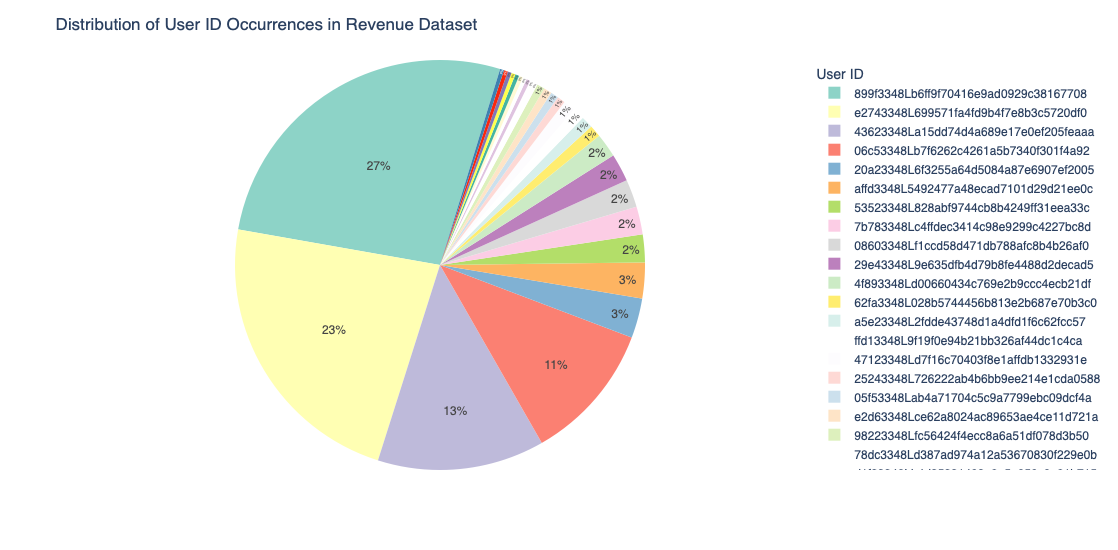

In [124]:
# calculate the distribution of user IDs as a percentage
user_id_distribution = revenue['userId'].value_counts(normalize=True) * 100
user_id_distribution_df = user_id_distribution.reset_index()
user_id_distribution_df.columns = ['userId', 'percentage']

# create a pie chart with the user ID distribution
fig = px.pie(user_id_distribution_df, 
             values='percentage', 
             names='userId', 
             color_discrete_sequence=px.colors.qualitative.Set3)

fig.update_traces(textposition='inside', 
                  rotation=280, 
                  texttemplate="%{percent:.0%}")

fig.update_layout(
    title='Distribution of User ID Occurrences in Revenue Dataset',
    legend_title='User ID',
    height=550,
    width=700
)
        
write(fig, 'revenue_user_id_distribution')

<span style="font-family:Helvetica Light">

From above, we can see that a few userId values contribute significantly to the revenue dataset, with the top 4 user IDs contributing nearly 73% of the total records.

Given this information, we can focus on analyzing these key userId values further to understand their impact on revenue. We can also explore how ad spend and installs correlate with these high-impact users if we can align this data effectively.

There are only 29 users in total in the revenue dataset, meaning there are only 29 users that generated some revenue on January 1, 2024.

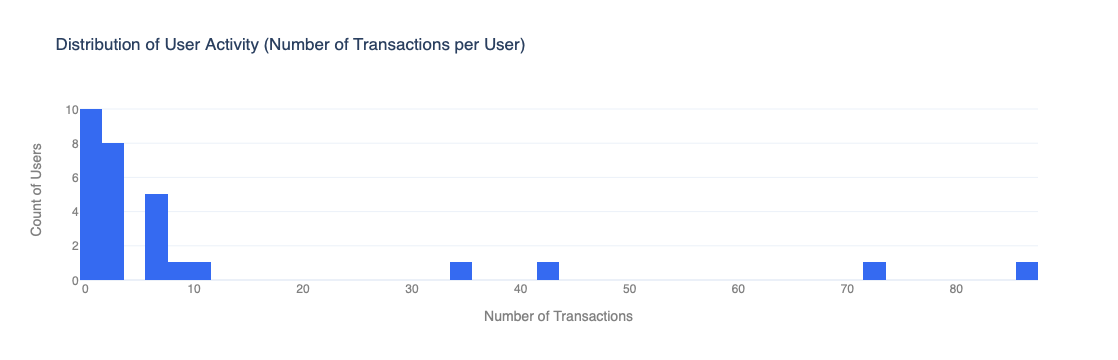

In [125]:
# plot the distribution of user activity
user_activity = revenue['userId'].value_counts()
fig = px.histogram(
    user_activity, 
    x=user_activity, 
    nbins=50, 
    title='Distribution of User Activity (Number of Transactions per User)',
    color_discrete_sequence=justplay_colors)

fig.update_layout(xaxis_title='Number of Transactions', yaxis_title='Count of Users')

write(fig, 'revenue_user_activity')

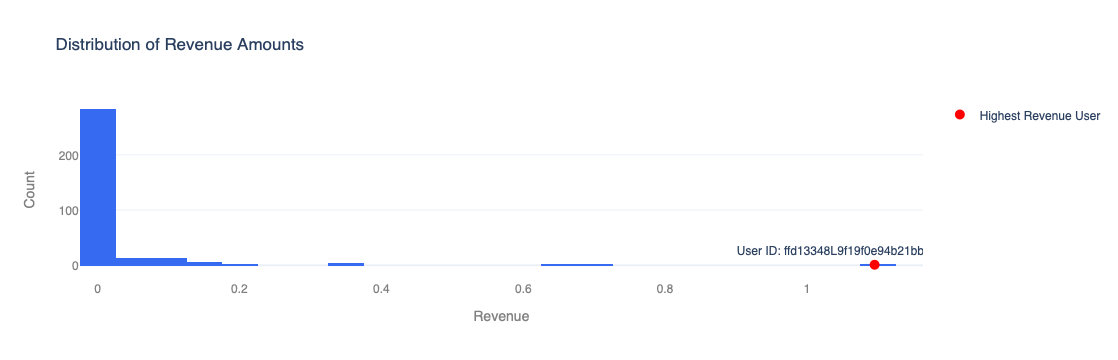

In [126]:
# plot the distribution of revenue amounts
fig = px.histogram(
    revenue, 
    x='amount', 
    nbins=30, 
    title='Distribution of Revenue Amounts', 
    color_discrete_sequence=justplay_colors)

# get the user ID and amount of the highest revenue
highest_revenue_row = revenue.loc[revenue['amount'].idxmax()]
highest_revenue_user_id = highest_revenue_row['userId']
highest_revenue_amount = highest_revenue_row['amount']

# add a marker for the user with the highest revenue amount
fig.add_trace(
    go.Scatter(
        x=[highest_revenue_amount],
        y=[1],  # Arbitrary y value to place the marker
        mode='markers+text',
        name='Highest Revenue User',
        text=[f'User ID: {highest_revenue_user_id}'],
        textposition='top center',
        marker=dict(color='red', size=10)
    )
)

fig.update_layout(
    xaxis_title='Revenue',
    yaxis_title='Count'
)

write(fig, 'revenue_distribution')

<span style="font-family:Helvetica Light">
    
The histogram of revenue amounts for a single day reveals a highly right-skewed distribution, indicating that most transactions are of small amounts with only a few high-value outliers. This suggests that JustPlay relies on a high volume of small transactions, and there is potential for growth. By understanding the characteristics of high-value transactions, strategies can be developed to increase the frequency of such transactions or to encourage more mid-range transactions.

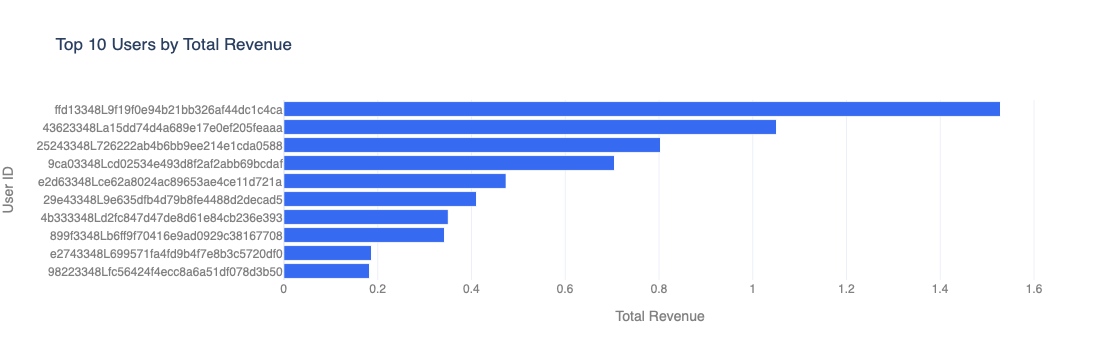

In [127]:
# calculate the total revenue per user
user_revenue = revenue.groupby('userId')['amount'].sum().reset_index()
user_revenue_sorted = user_revenue.sort_values(by='amount', ascending=False)

# select the top 10 users
top_users = user_revenue_sorted.head(10)

# create the bar plot for the top users by total revenue
fig = px.bar(
    top_users, 
    y='userId', 
    x='amount', 
    title='Top 10 Users by Total Revenue', 
    orientation='h',
    color_discrete_sequence=justplay_colors)

fig.update_layout(
    xaxis_title='Total Revenue',
    yaxis_title='User ID',
    yaxis={'categoryorder':'total ascending'}
)

write(fig, 'revenue_top_10_users')

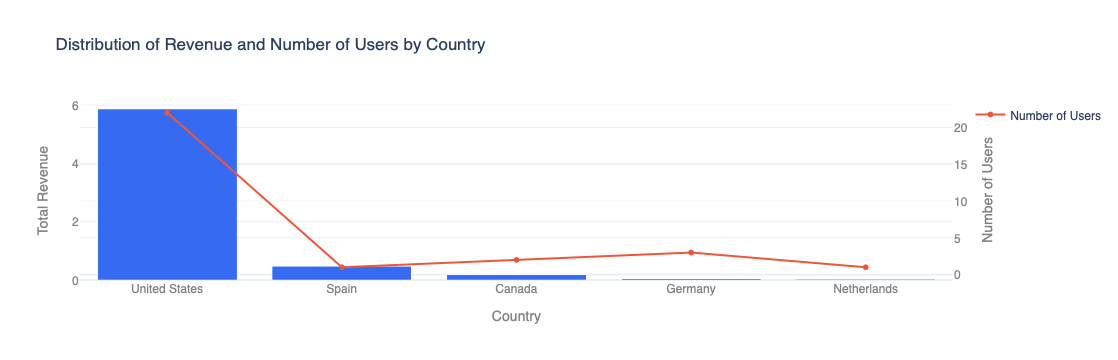

In [128]:
# calculate the total revenue and number of unique users by country
country_revenue = revenue.groupby('countryName')['amount'].sum().reset_index()
country_users = revenue.groupby('countryName')['userId'].nunique().reset_index()

country_stats = pd.merge(country_revenue, country_users, on='countryName')
country_stats.columns = ['Country', 'Total Revenue', 'Number of Users']

country_stats = country_stats.sort_values(by='Total Revenue', ascending=False)

# create the bar plot for total revenue by country
fig = px.bar(country_stats, 
             x='Country', 
             y='Total Revenue', 
             title='Distribution of Revenue by Country',
             color_discrete_sequence=justplay_colors)

# add a scatter plot for the number of users on the secondary y-axis
fig.add_trace(
    go.Scatter(
        x=country_stats['Country'], 
        y=country_stats['Number of Users'], 
        mode='markers+lines', 
        name='Number of Users',
        yaxis='y2'
    )
)

fig.update_layout(
    yaxis=dict(title='Total Revenue'),
    yaxis2=dict(title='Number of Users', overlaying='y', side='right'),
    xaxis_title='Country',
    title='Distribution of Revenue and Number of Users by Country'
)

write(fig, 'revenue_top_10_users')

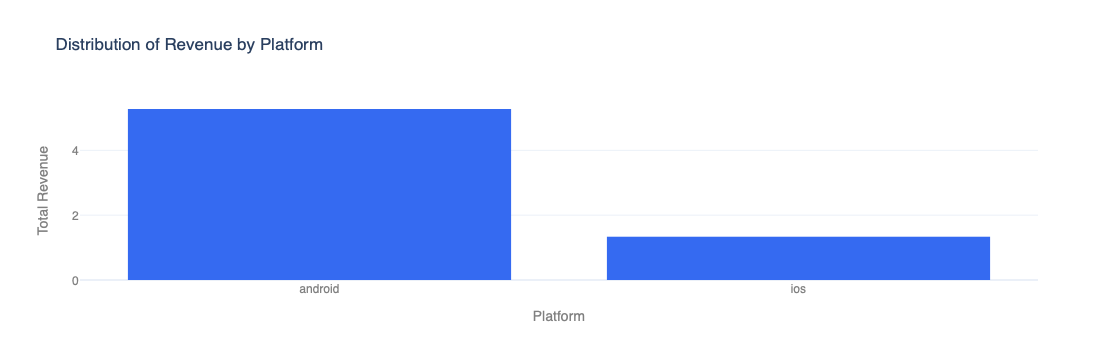

In [129]:
# plot the distribution of revenue by platform
fig = px.histogram(
    revenue, 
    x='platform', 
    y='amount', 
    histfunc='sum', 
    title='Distribution of Revenue by Platform',
    color_discrete_sequence=justplay_colors)

fig.update_layout(
    xaxis_title='Platform', 
    yaxis_title='Total Revenue')

write(fig, 'revenue_top_10_users')

In [130]:
revenue.to_csv('../data/processed/revenue.csv', index=False)

<span style="font-family:Helvetica Light">

#### *Add Spend Installs Dataset*
#### 2.1. Data Loading

In [131]:
ad_spend_installs = pd.read_csv('../data/raw/ad_spend_installs_2024_01_01.csv')
print(ad_spend_installs.shape)
ad_spend_installs.head()

(103, 12)


,report_day,country_code,os_name,network_clicks,network_impressions,network_installs,network_installs_diff,installs,cost,channel,campaign,creative
0,2024-01-01,gb,android,68,5406,239,239,0,151.3229,channel 1,campaign 1,creative 1
1,2024-01-01,us,android,14776,934292,24334,24334,0,24081.0339,channel 1,campaign 2,creative 1
2,2024-01-01,no,android,52,2961,143,143,0,58.5570,channel 1,campaign 3,creative 1
3,2024-01-01,pl,android,0,0,0,357,357,0.0000,channel 1,campaign 4,creative 2
4,2024-01-01,be,android,0,0,0,1,1,0.0000,channel 1,campaign 5,creative 3


<span style="font-family:Helvetica Light">

#### 1.2. Data Cleaning

##### 1.2.1. Missing Values Analysis

In [132]:
ad_spend_installs.isnull().sum()/len(ad_spend_installs)*100

report_day               0.0
country_code             0.0
os_name                  0.0
network_clicks           0.0
network_impressions      0.0
network_installs         0.0
network_installs_diff    0.0
installs                 0.0
cost                     0.0
channel                  0.0
campaign                 0.0
creative                 0.0
dtype: float64

<span style="font-family:Helvetica Light">

##### 1.2.2. Duplicates Detection

In [133]:
# print the number of duplicate rows
print(f'Number of duplicate rows in ad_spend: {ad_spend_installs.duplicated().sum()}')

Number of duplicate rows in ad_spend: 0


<span style="font-family:Helvetica Light">

There are no missing values and no duplicates in ad spend installs dataset.

<span style="font-family:Helvetica Light">

##### 1.2.2. Data Types Validation

In [134]:
ad_spend_installs.dtypes

report_day                object
country_code              object
os_name                   object
network_clicks             int64
network_impressions        int64
network_installs           int64
network_installs_diff      int64
installs                   int64
cost                     float64
channel                   object
campaign                  object
creative                  object
dtype: object

In [135]:
# convert 'report_day' column to datetime
ad_spend_installs['report_day'] = pd.to_datetime(ad_spend_installs['report_day'])
print(ad_spend_installs.report_day.value_counts())

# transform specific columns to category
# cat_columns = ['country_code', 'os_name', 'channel', 'campaign', 'creative']
# ad_spend_installs[cat_columns] = ad_spend_installs[cat_columns].astype('category')

report_day
2024-01-01    103
Name: count, dtype: int64


In [136]:
ad_spend_installs['country_name'] = ad_spend_installs['country_code'].apply(lambda x: pycountry.countries.get(alpha_2=x).name)

In [137]:
ad_spend_installs = ad_spend_installs[['report_day', 'country_code', 'country_name', 'os_name', 'channel', 'campaign', 'creative', 'network_clicks', 'network_impressions', 'network_installs', 'installs', 'network_installs_diff', 'cost']].sort_values(['country_code', 'os_name', 'channel', 'campaign', 'creative'])

In [138]:
# calculate the absolute difference between installs and network installs and check if it matches the existing 'network_installs_diff' column
ad_spend_installs.loc[ad_spend_installs['network_installs_diff'] != abs(ad_spend_installs['network_installs'] - ad_spend_installs['installs'])]

,report_day,country_code,country_name,os_name,channel,campaign,creative,network_clicks,network_impressions,network_installs,installs,network_installs_diff,cost


<span style="font-family:Helvetica Light">

In our dataset, we have two sources reporting the number of installs: the channel (network_installs) and the attribution provider, Adjust (installs). Additionally, we also have the difference between these two reports (network_installs_diff). Typically, attribution providers like Adjust are specialized in tracking and attributing installs accurately. They have robust mechanisms to deduplicate installs and correctly attribute them to the right source, making installs from Adjust generally more reliable. In contrast, channels might over-report installs due to their incentive to show better performance. For reliable reporting and analysis, installs from Adjust should be used as the primary metric. The network_installs_diff can be used to monitor discrepancies between the channel and Adjust, which can help identify potential reporting issues or fraud.

It is worth noting that the highest difference is observed in the US for channel 1, campaign 2, and creative 1. This raises the question of whether this is an outlier or if it makes sense that the US would have the highest metric. To address these discrepancies, I would communicate with the channels to understand their reporting methodologies and identify any potential issues. Additionally, I would engage with Adjust to validate their tracking accuracy and methodologies.

Moreover, we should consider whether to exclude potential outliers where differences are greater than a certain threshold. Identifying and excluding these outliers can prevent them from skewing the analysis and provide a clearer understanding of the data trends.

In [139]:
# using IQR to filter out outliers
# calculate IQR
Q1 = ad_spend_installs['network_installs_diff'].quantile(0.01) # we can change these thresholds
Q3 = ad_spend_installs['network_installs_diff'].quantile(0.99)
IQR = Q3 - Q1

# define the lower and upper bound for outliers
lower_bound = Q1 - 1.5 * IQR
print(lower_bound)
upper_bound = Q3 + 1.5 * IQR
print(upper_bound)

# exclude outliers
filtered_ad_spend_installs = ad_spend_installs[(ad_spend_installs['network_installs_diff'] >= lower_bound) & 
(ad_spend_installs['network_installs_diff'] <= upper_bound)]

filtered_ad_spend_installs.shape

-5761.3500000000095
9602.250000000015


(102, 13)

<span style="font-family:Helvetica Light">

#### 2.3. Summary Statistics

In [140]:
ad_spend_installs.describe(include='all')

,report_day,country_code,country_name,os_name,channel,campaign,creative,network_clicks,network_impressions,network_installs,installs,network_installs_diff,cost
count,103,103,103,103,103,103,103,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000
unique,NaN,15,15,2,10,44,77,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,us,United States,android,channel 8,campaign 22,creative 1,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,72,72,59,22,9,10,NaN,NaN,NaN,NaN,NaN,NaN
mean,2024-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,1456.553398,28470.252427,336.893204,20.456311,332.864078,354.941214
min,2024-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2024-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,3.500000,184.500000,0.000000,0.000000,0.000000,1.396850
50%,2024-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,91.000000,1741.000000,3.000000,1.000000,1.000000,23.966100
75%,2024-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,614.000000,5564.000000,16.500000,15.500000,8.000000,84.566800
max,2024-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,66127.000000,934292.000000,24334.000000,407.000000,24334.000000,24081.033900


<span style="font-family:Helvetica Light">

#### 2.3. Distribution Plots

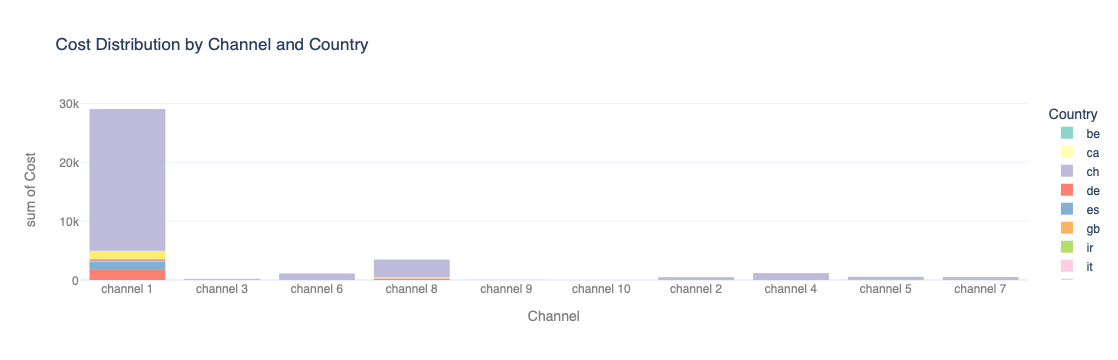

In [141]:
# cost distribution by channel
fig = px.histogram(
    ad_spend_installs, 
    x='channel', 
    y='cost', 
    color='country_code', 
    title='Cost Distribution by Channel and Country', 
    labels={'cost': 'Cost', 'channel': 'Channel', 'country_code': 'Country'},
    color_discrete_sequence=px.colors.qualitative.Set3)

write(fig, 'ad_spend_installs_cost_distribution')

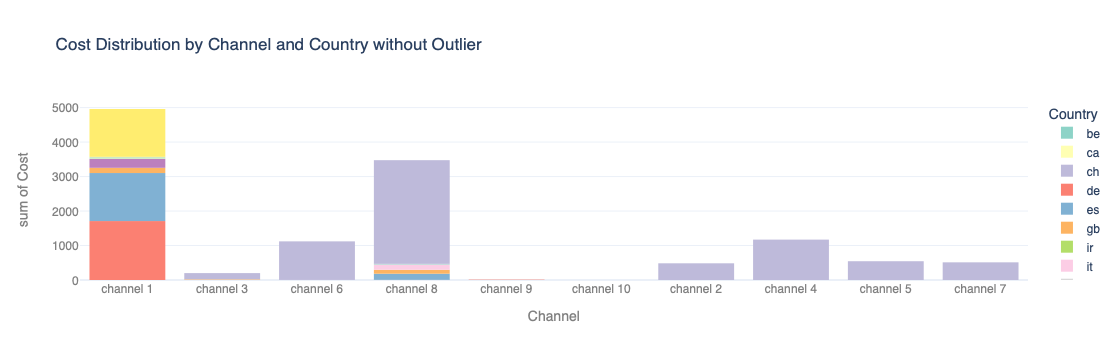

In [142]:
# cost distribution by channel and country without outlier
fig = px.histogram(
    filtered_ad_spend_installs, 
    x='channel', 
    y='cost', 
    color='country_code', 
    title='Cost Distribution by Channel and Country without Outlier', 
    labels={'cost': 'Cost', 'channel': 'Channel', 'country_code': 'Country'},
    color_discrete_sequence=px.colors.qualitative.Set3)

write(fig, 'ad_spend_installs_cost_distribution_without_outlier')

In [143]:
ad_spend_installs.to_csv('../data/processed/ad_spend_installs.csv', index=False)

In [144]:
filtered_ad_spend_installs.to_csv('../data/processed/ad_spend_installs_without_outliers.csv', index=False)

<span style="font-family:Helvetica Light">

### 3. Data Joining

In [145]:
agg_funcs = {
    'amount': 'sum'
}

remaining_cols = revenue.columns.difference(['userId', 'amount'])

for col in remaining_cols:
    if revenue[col].dtype == 'object':
        agg_funcs[col] = lambda x: x.unique().tolist() if len(x.unique()) > 1 else x.unique()[0]
    elif revenue[col].dtype == 'datetime64[ns, UTC]':
        agg_funcs[col] = lambda x: x.tolist()  
    else:
        agg_funcs[col] = 'sum'

# group by userId and aggregate
summarized_revenue = revenue.groupby('userId').agg(agg_funcs).reset_index()

# add a column that counts the number of events per userId
event_counts = revenue.groupby('userId')['eventId'].count().reset_index()
event_counts.rename(columns={'eventId': 'eventCount'}, inplace=True)

summarized_revenue = pd.merge(summarized_revenue, event_counts, on='userId', how='left')
    
summarized_revenue.head()

,userId,amount,adUnitFormat,adUnitName,advertisingId,countryCode,countryName,createdAt,createdDate,deviceId,eventId,network,packageName,platform,source,eventCount
0,05f53348Lab4a71704c5c9a7799ebc09dcf4a,0.052597,adUnitFormat 1,adUnitName 1,QJGE25787236863773,de,Germany,"[2024-01-01 14:27:43.914488+00:00, 2024-01-01 ...",2024-01-01,TTCE01213474647282,"[HXJR70499520564369, QOUW24682420424542]",network 1,packageName 1,android,source 1,2
1,06c53348Lb7f6262c4261a5b7340f301f4a92,0.006181,adUnitFormat 1,adUnitName 1,WYWS55356535259373,ca,Canada,"[2024-01-01 04:19:04.281771+00:00, 2024-01-01 ...",2024-01-01,OPDS19296982968073,"[ACVH81800365309399, AJIE67942237150314, NMFD2...","[network 1, network 11]",packageName 1,android,source 1,35
2,08603348Lf1ccd58d471db788afc8b4b26af0,0.115277,"[adUnitFormat 3, adUnitFormat 2]","[adUnitName 7, adUnitName 8, adUnitName 18]",WHTG32858174869758,us,United States,"[2024-01-01 01:16:54.888996+00:00, 2024-01-01 ...",2024-01-01,XGTT77524482245241,"[YVHD02161867918500, IBTA21881429797948, PBTJ6...","[network 5, network 1]","[packageName 3, packageName 4]",ios,source 1,7
3,20a23348L6f3255a64d5084a87e6907ef2005,0.104815,"[adUnitFormat 2, adUnitFormat 3]","[adUnitName 5, adUnitName 9, adUnitName 17]",SUQI74040824240185,us,United States,"[2024-01-01 02:28:39.033802+00:00, 2024-01-01 ...",2024-01-01,GWVQ53818041567948,"[ZKZU42361185325324, IDPW23212085528505, QLCH5...","[network 3, network 5, network 13, network 8, ...","[packageName 2, packageName 3]",android,source 1,10
4,25243348L726222ab4b6bb9ee214e1cda0588,0.802977,adUnitFormat 4,adUnitName 16,MVNH76971032880472,us,United States,"[2024-01-01 23:15:04.957865+00:00, 2024-01-01 ...",2024-01-01,YCNR63263280188324,"[QHDP85621363002923, EUBC64466361540463]",network 10,packageName 7,android,source 2,2


In [146]:
merged_installs_revenue = pd.merge(installs, summarized_revenue, on=['userId'], how='outer', indicator=True)
print(installs.shape)
print(summarized_revenue.shape)
print(merged_installs_revenue.shape)
merged_installs_revenue.head()

(95, 15)
(29, 16)
(95, 31)


,userId,countryCode_x,installedAt,osVersion,device,limitAdTracking,adjustId,adGroupName,trackerName,channel,campaign,creative,os_name,installedDate,countryName_x,amount,adUnitFormat,adUnitName,advertisingId,countryCode_y,countryName_y,createdAt,createdDate,deviceId,eventId,network,packageName,platform,source,eventCount,_merge
0,47123348Ld7f16c70403f8e1affdb1332931e,ca,2024-01-01 17:23:46+00:00,9,galaxya50,False,EJRY87002175420325,adGroupName 1,trackerName 1,channel 1,campaign 1,creative 1,android,2024-01-01,Canada,0.028306,adUnitFormat 1,adUnitName 1,PJDF37672139806354,nl,Netherlands,"[2024-01-01 09:19:52.900940+00:00, 2024-01-01 ...",2024-01-01,OCNZ40740081001824,"[GGXB32293442357576, ZFAS45155583461209, VHHS6...","[network 1, network 9]",packageName 1,android,source 1,3.0,both
1,98223348Lfc56424f4ecc8a6a51df078d3b50,ca,2024-01-01 03:08:35+00:00,9,galaxys22ultra5g,False,OQJA99166154683474,adGroupName 55,trackerName 58,channel 9,campaign 22,creative 37,android,2024-01-01,Canada,0.182510,adUnitFormat 1,adUnitName 1,BTFB55314981998668,ca,Canada,"[2024-01-01 03:27:11.653079+00:00, 2024-01-01 ...",2024-01-01,MUKJ31662517026062,"[UFOA50316346323353, GSFJ54230156274976]","[network 1, network 9]",packageName 1,android,source 1,2.0,both
2,50653348Le377569f4c0b97c211d3c6a185cc,gb,2024-01-01 10:51:47+00:00,9,galaxya8(2018),False,XXOH42898890122016,adGroupName 54,trackerName 57,channel 9,campaign 21,creative 27,android,2024-01-01,United Kingdom,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3,2e803348Lb3e5dfad4133943aa10b8349a704,de,2024-01-01 12:56:25+00:00,9,galaxys8,False,KLAB91443783264247,adGroupName 54,trackerName 56,channel 9,campaign 20,creative 36,android,2024-01-01,Germany,0.000179,adUnitFormat 2,adUnitName 3,TCYX74674601195454,de,Germany,[2024-01-01 13:03:24.676989+00:00],2024-01-01,PXMM53226701652285,PUFK31153656818899,network 2,packageName 2,android,source 1,1.0,both
4,57893348L8954cfdf4b389d80a5d804b00fe0,de,2024-01-01 17:34:59+00:00,9,galaxynote8,False,YDZY92754243116752,adGroupName 53,trackerName 55,channel 9,campaign 20,creative 35,android,2024-01-01,Germany,0.000254,adUnitFormat 2,adUnitName 10,LLPE93394264688921,de,Germany,[2024-01-01 20:54:31.609564+00:00],2024-01-01,YSPB22903207893694,VIJE54966397157283,network 5,packageName 3,android,source 1,1.0,both


In [147]:
merged_installs_revenue._merge.value_counts()

_merge
left_only     66
both          29
right_only     0
Name: count, dtype: int64

<span style="font-family:Helvetica Light">

#### Explanation for Different Country Codes and Timestamps in Installs and Revenue Datasets
Different country codes and timestamps in the merged installs and revenue datasets could be attributed to different data collection times or the use of different data sources. The *'countryCode_x'* is recorded at the time of installation (*'installedAt'*), while *'countryCode_y'* is captured at the time of a revenue event (*'createdAt'*). A possible explanation could be that installs data may derive country codes from device settings or IP addresses, whereas revenue data might rely on third-party revenue tracking tools, resulting in inconsistencies due to varying data collection methodologies.

Moreover, in some cases, *'createdAt'* (revenue timestamp) appears earlier than installedAt (installation timestamp) due to potential data inconsistencies or errors in data logging and synchronization. Different data sources can introduce discrepancies, as the revenue data might be captured and recorded faster than the installation data, particularly if the two events are reported by separate systems or services. Additionally, delayed installation reporting can occur if the device's internet connection is unstable or unavailable at the time of installation, causing the installation event to be logged later than the actual time it occurred.

In [148]:
merged_installs_revenue['eventCount'] = merged_installs_revenue['eventCount'].fillna(0).astype(int)

In [149]:
merged_installs_revenue[['os_name', 'platform', '_merge']].loc[merged_installs_revenue.os_name!=merged_installs_revenue.platform]

,os_name,platform,_merge
2,android,NaN,left_only
5,android,NaN,left_only
6,android,NaN,left_only
7,android,NaN,left_only
8,android,NaN,left_only
9,android,NaN,left_only
10,android,NaN,left_only
14,android,NaN,left_only
15,android,NaN,left_only
17,android,NaN,left_only


In [150]:
merged_installs_revenue.rename(columns={
    'countryName_x': 'countryName_installs',
    'countryName_y': 'countryName_revenue'
}, inplace=True)

In [151]:
merged_installs_revenue.head()

,userId,countryCode_x,installedAt,osVersion,device,limitAdTracking,adjustId,adGroupName,trackerName,channel,campaign,creative,os_name,installedDate,countryName_installs,amount,adUnitFormat,adUnitName,advertisingId,countryCode_y,countryName_revenue,createdAt,createdDate,deviceId,eventId,network,packageName,platform,source,eventCount,_merge
0,47123348Ld7f16c70403f8e1affdb1332931e,ca,2024-01-01 17:23:46+00:00,9,galaxya50,False,EJRY87002175420325,adGroupName 1,trackerName 1,channel 1,campaign 1,creative 1,android,2024-01-01,Canada,0.028306,adUnitFormat 1,adUnitName 1,PJDF37672139806354,nl,Netherlands,"[2024-01-01 09:19:52.900940+00:00, 2024-01-01 ...",2024-01-01,OCNZ40740081001824,"[GGXB32293442357576, ZFAS45155583461209, VHHS6...","[network 1, network 9]",packageName 1,android,source 1,3,both
1,98223348Lfc56424f4ecc8a6a51df078d3b50,ca,2024-01-01 03:08:35+00:00,9,galaxys22ultra5g,False,OQJA99166154683474,adGroupName 55,trackerName 58,channel 9,campaign 22,creative 37,android,2024-01-01,Canada,0.182510,adUnitFormat 1,adUnitName 1,BTFB55314981998668,ca,Canada,"[2024-01-01 03:27:11.653079+00:00, 2024-01-01 ...",2024-01-01,MUKJ31662517026062,"[UFOA50316346323353, GSFJ54230156274976]","[network 1, network 9]",packageName 1,android,source 1,2,both
2,50653348Le377569f4c0b97c211d3c6a185cc,gb,2024-01-01 10:51:47+00:00,9,galaxya8(2018),False,XXOH42898890122016,adGroupName 54,trackerName 57,channel 9,campaign 21,creative 27,android,2024-01-01,United Kingdom,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,left_only
3,2e803348Lb3e5dfad4133943aa10b8349a704,de,2024-01-01 12:56:25+00:00,9,galaxys8,False,KLAB91443783264247,adGroupName 54,trackerName 56,channel 9,campaign 20,creative 36,android,2024-01-01,Germany,0.000179,adUnitFormat 2,adUnitName 3,TCYX74674601195454,de,Germany,[2024-01-01 13:03:24.676989+00:00],2024-01-01,PXMM53226701652285,PUFK31153656818899,network 2,packageName 2,android,source 1,1,both
4,57893348L8954cfdf4b389d80a5d804b00fe0,de,2024-01-01 17:34:59+00:00,9,galaxynote8,False,YDZY92754243116752,adGroupName 53,trackerName 55,channel 9,campaign 20,creative 35,android,2024-01-01,Germany,0.000254,adUnitFormat 2,adUnitName 10,LLPE93394264688921,de,Germany,[2024-01-01 20:54:31.609564+00:00],2024-01-01,YSPB22903207893694,VIJE54966397157283,network 5,packageName 3,android,source 1,1,both


In [152]:
merged_installs_revenue.to_csv('../data/processed/merged_installs_revenue.csv', index=False)

In [153]:
# analyze ad performance across different ad groups
ad_performance_metrics = merged_installs_revenue.groupby(['channel', 'campaign', 'creative'], dropna=False).agg({
    'amount': 'sum',          
    'userId': 'count',       
    'eventCount': 'sum'          
}).reset_index()

ad_performance_metrics.rename(columns={
    'amount': 'revenue_2024_01_01',
    'userId': 'installs/users_2024_01_01',
    'eventCount': 'events_2024_01_01'
}, inplace=True)

print("Ad Performance Metrics:")
ad_performance_metrics.head(10)

Ad Performance Metrics:


,channel,campaign,creative,revenue_2024_01_01,installs/users_2024_01_01,events_2024_01_01
0,channel 1,campaign 1,creative 1,0.028306,1,3
1,channel 1,campaign 2,creative 1,0.006181,1,35
2,channel 1,campaign 2,creative 3,0.000000,1,0
3,channel 1,campaign 3,creative 2,0.186441,1,73
4,channel 1,campaign 8,creative 10,0.000000,2,0
5,channel 1,campaign 9,creative 10,0.000000,1,0
6,channel 10,campaign 23,creative 39,1.368699,13,20
7,channel 10,campaign 23,creative 40,0.001007,4,1
8,channel 2,campaign 4,creative 4,0.000000,2,0
9,channel 2,campaign 5,creative 5,0.473510,2,2


In [154]:
# group by 'channel', 'campaign', 'creative', 'os_name', 'countryName_installs', and 'countryName_revenue'
# calculate the sum of 'amount', count of 'userId', and count of 'eventId' for each group
ad_performance_metrics_per_country_and_os = merged_installs_revenue.groupby(
    ['channel', 'campaign', 'creative', 'os_name', 'countryName_installs', 'countryName_revenue'], dropna=False).agg({
    'amount': 'sum',          
    'userId': 'count',        
    'eventCount': 'count'        
}).reset_index()

ad_performance_metrics_per_country_and_os.rename(columns={
    'amount': 'revenue_2024_01_01',
    'userId': 'installs/users_2024_01_01',
    'eventCount': 'events_2024_01_01'
}, inplace=True)

print("Ad Performance Metrics per Country and OS:")
ad_performance_metrics_per_country_and_os.head(10)

Ad Performance Metrics per Country and OS:


,channel,campaign,creative,os_name,countryName_installs,countryName_revenue,revenue_2024_01_01,installs/users_2024_01_01,events_2024_01_01
0,channel 1,campaign 1,creative 1,android,Canada,Netherlands,0.028306,1,1
1,channel 1,campaign 2,creative 1,android,Australia,Canada,0.006181,1,1
2,channel 1,campaign 2,creative 3,android,United States,NaN,0.000000,1,1
3,channel 1,campaign 3,creative 2,android,Germany,United States,0.186441,1,1
4,channel 1,campaign 8,creative 10,ios,United States,NaN,0.000000,2,2
5,channel 1,campaign 9,creative 10,ios,United States,NaN,0.000000,1,1
6,channel 10,campaign 23,creative 39,android,United States,United States,1.368699,4,4
7,channel 10,campaign 23,creative 39,android,United States,NaN,0.000000,2,2
8,channel 10,campaign 23,creative 39,ios,United States,NaN,0.000000,7,7
9,channel 10,campaign 23,creative 40,android,United States,United States,0.001007,1,1


In [155]:
ad_performance_metrics_per_channel = merged_installs_revenue.groupby(['channel'], dropna=False).agg({
    'amount': 'sum',          
    'userId': 'count',       
    'eventCount': 'sum'          
}).reset_index()

ad_performance_metrics_per_channel.rename(columns={
    'amount': 'revenue_2024_01_01',
    'userId': 'installs/users_2024_01_01',
    'eventCount': 'events_2024_01_01'
}, inplace=True)

print("Ad Performance Metrics per Channel:")
ad_performance_metrics_per_channel.head(10)

Ad Performance Metrics per Channel:


,channel,revenue_2024_01_01,installs/users_2024_01_01,events_2024_01_01
0,channel 1,0.220928,7,111
1,channel 10,1.369706,17,21
2,channel 2,0.473510,4,2
3,channel 3,0.342264,11,86
4,channel 4,1.878078,9,4
5,channel 5,0.013704,4,10
6,channel 6,1.165710,13,49
7,channel 7,0.718040,9,5
8,channel 8,0.050334,1,1
9,channel 9,0.377860,20,30


In [156]:
ad_performance_metrics_per_channel.revenue_2024_01_01.sum()

6.610135683

In [157]:
ad_performance_metrics_per_channel['installs/users_2024_01_01'].sum()

95

In [158]:
# group by 'channel' and sum all numerical columns
columns_to_sum = [
    'network_clicks', 'network_impressions', 'network_installs',
    'installs', 'network_installs_diff', 'cost'
]

ad_installs_performance_metrics_per_channel = ad_spend_installs.groupby('channel')[columns_to_sum].sum().reset_index()
ad_installs_performance_metrics_per_channel_without_outliers = filtered_ad_spend_installs.groupby('channel')[columns_to_sum].sum().reset_index()
ad_installs_performance_metrics_per_channel.head(10)

,channel,network_clicks,network_impressions,network_installs,installs,network_installs_diff,cost
0,channel 1,22148,1477049,33275,488,33763,29039.9444
1,channel 10,0,0,0,243,243,0.0000
2,channel 2,2947,681745,85,0,85,484.2560
3,channel 3,6380,170249,49,2,47,200.2379
4,channel 4,599,161172,16,118,102,1171.2400
5,channel 5,8856,32425,202,201,1,544.5124
6,channel 6,4538,39914,187,187,2,1120.4695
7,channel 7,228,22406,31,6,25,512.3900
8,channel 8,104329,347301,855,862,17,3475.0498
9,channel 9,0,175,0,0,0,10.8450


In [159]:
merged_data = pd.merge(installs, ad_spend_installs, on=['channel', 'campaign', 'creative'], how='inner')
print(merged_data.shape)
merged_data = pd.merge(ad_spend_installs, ad_performance_metrics_per_country_and_os, on=['channel', 'campaign', 'creative'], how='inner')
print(merged_data.shape)

(3, 25)
(3, 19)


<span style="font-family:Helvetica Light">

When I attempted to merge the ad spend installs dataset with ad performance metrics at the channel, campaign, and creative level, there were only 3 matches. This low number of matches suggests that the detailed level of granularity (combining channel, campaign, and creative) may not have sufficient overlap between the datasets, possibly due to discrepancies or incomplete data in one or both sources. To address this issue and gain meaningful insights, I decided to aggregate the data at the channel level instead. By focusing on ad performance per channel, I aim to achieve a broader and more comprehensive understanding of ad performance while ensuring a higher number of matches between the datasets.

In [160]:
ad_performance_metrics_per_channel = pd.merge(ad_performance_metrics_per_channel, ad_installs_performance_metrics_per_channel, on=['channel'], how='outer')

In [161]:
ad_performance_metrics_per_channel.head(100)

,channel,revenue_2024_01_01,installs/users_2024_01_01,events_2024_01_01,network_clicks,network_impressions,network_installs,installs,network_installs_diff,cost
0,channel 1,0.220928,7,111,22148,1477049,33275,488,33763,29039.9444
1,channel 10,1.369706,17,21,0,0,0,243,243,0.0000
2,channel 2,0.473510,4,2,2947,681745,85,0,85,484.2560
3,channel 3,0.342264,11,86,6380,170249,49,2,47,200.2379
4,channel 4,1.878078,9,4,599,161172,16,118,102,1171.2400
5,channel 5,0.013704,4,10,8856,32425,202,201,1,544.5124
6,channel 6,1.165710,13,49,4538,39914,187,187,2,1120.4695
7,channel 7,0.718040,9,5,228,22406,31,6,25,512.3900
8,channel 8,0.050334,1,1,104329,347301,855,862,17,3475.0498
9,channel 9,0.377860,20,30,0,175,0,0,0,10.8450


In [162]:
ad_performance_metrics_per_channel_without_outliers = pd.merge(ad_performance_metrics_per_channel, ad_installs_performance_metrics_per_channel_without_outliers, on=['channel'], how='outer')

In [163]:
ad_performance_metrics_per_channel.to_csv('../data/processed/ad_performance_metrics_per_channel.csv', index=False)
ad_performance_metrics_per_channel_without_outliers.to_csv('../data/processed/ad_performance_metrics_per_channel_without_outliers.csv', index=False)

<span style="font-family:Helvetica Light">

### 4. Metrics Derivation/Calculation

From the provided datasets, we can derive several key metrics related to advertising performance, user acquisition, and revenue generation.

#### ***Key Performance Indicators (KPIs)***

- **Cost Per Install (CPI)**: Measures the efficiency of advertising spend in acquiring new users.
$$\text{CPI} = \frac{\text{Total Cost}}{\text{Total Installs}}$$ 

- **Cost Per Click (CPC)**: Measures the cost incurred for each click on an advertisement.
$$\text{CPC} = \frac{\text{Total Cost}}{\text{Total Network Clicks}}$$
 
- **Click-Through Rate (CTR)**: Indicates the effectiveness of ad creatives in generating user interest.
$$\text{CTR} = \frac{\text{Network Clicks}}{\text{Network Impressions}}$$

- **Conversion Rate**: Measures the proportion of users who perform a desired action (e.g., installing an app) after clicking on an ad. $$\text{Conversion Rate} = \frac{\text{Installs}}{\text{Network Clicks}}$$

- **Install Rate**: Assesses the conversion rate from ad clicks to app installs.
$$\text{Install Rate} = \frac{\text{Installs}}{\text{Network Impressions}}$$

- **Revenue Per Install (RPI)**: Measures the average revenue generated from each install.
$$\text{RPI} = \frac{\text{Total Revenue}}{\text{Total Installs}}$$

- **Return on Ad Spend (ROAS)**: Evaluates the revenue generated for every dollar spent on advertising.
$$\text{ROAS} = \frac{\text{Total Revenue}}{\text{Total Cost}}$$

- **Average Revenue Per User (ARPU)**: Measures the average revenue generated per user, highlighting monetization efficiency.
$$\text{ARPU} = \frac{\text{Total Revenue}}{\text{Number of Unique Users}}$$

- **Return on Investment (ROI)**: Measures the profitability of the advertising campaign.
$$\text{ROI} = \frac{\text{Total Revenue} - \text{Total Cost}}{\text{Total Cost}}$$

In [164]:
# calculating the metrics
ad_performance_metrics_per_channel['CPI'] = ad_performance_metrics_per_channel['cost'] / ad_performance_metrics_per_channel['installs']
ad_performance_metrics_per_channel['CPC'] = ad_performance_metrics_per_channel['cost'] / ad_performance_metrics_per_channel['network_clicks']
ad_performance_metrics_per_channel['CTR'] = (ad_performance_metrics_per_channel['network_clicks'] / ad_performance_metrics_per_channel['network_impressions']) * 100
ad_performance_metrics_per_channel['conversion_rate'] = (ad_performance_metrics_per_channel['network_installs'] / ad_performance_metrics_per_channel['network_clicks']) * 100
ad_performance_metrics_per_channel['install_rate'] = (ad_performance_metrics_per_channel['network_installs'] / ad_performance_metrics_per_channel['network_impressions']) * 100
ad_performance_metrics_per_channel['RPI'] = ad_performance_metrics_per_channel['revenue_2024_01_01'] / ad_performance_metrics_per_channel['installs']
ad_performance_metrics_per_channel['ROAS'] = ad_performance_metrics_per_channel['revenue_2024_01_01'] / ad_performance_metrics_per_channel['cost']
ad_performance_metrics_per_channel['ARPU'] = ad_performance_metrics_per_channel['revenue_2024_01_01'] / ad_performance_metrics_per_channel['installs/users_2024_01_01']
ad_performance_metrics_per_channel['ROI'] = ((ad_performance_metrics_per_channel['revenue_2024_01_01'] - ad_performance_metrics_per_channel['cost']) / ad_performance_metrics_per_channel['cost']) * 100

# replacing NaN and infinity values with zero
ad_performance_metrics_per_channel = ad_performance_metrics_per_channel.fillna(0)
ad_performance_metrics_per_channel = ad_performance_metrics_per_channel.replace([float('inf'), float('-inf')], 0)

ad_performance_metrics_per_channel.head()

,channel,revenue_2024_01_01,installs/users_2024_01_01,events_2024_01_01,network_clicks,network_impressions,network_installs,installs,network_installs_diff,cost,CPI,CPC,CTR,conversion_rate,install_rate,RPI,ROAS,ARPU,ROI
0,channel 1,0.220928,7,111,22148,1477049,33275,488,33763,29039.9444,59.508083,1.311177,1.499476,150.239299,2.252803,0.000453,0.000008,0.031561,-99.999239
1,channel 10,1.369706,17,21,0,0,0,243,243,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005637,0.000000,0.080571,0.000000
2,channel 2,0.473510,4,2,2947,681745,85,0,85,484.2560,0.000000,0.164322,0.432273,2.884289,0.012468,0.000000,0.000978,0.118377,-99.902219
3,channel 3,0.342264,11,86,6380,170249,49,2,47,200.2379,100.118950,0.031385,3.747452,0.768025,0.028781,0.171132,0.001709,0.031115,-99.829071
4,channel 4,1.878078,9,4,599,161172,16,118,102,1171.2400,9.925763,1.955326,0.371653,2.671119,0.009927,0.015916,0.001603,0.208675,-99.839650


<span style="font-family:Helvetica Light">
    
If I had additional data available, I would derive other useful metrics such as: 
- **Lifetime Value (LTV)**: Predicts the long-term value of a user, guiding investment in user acquisition.
- **Retention Rate**: Measures user engagement and satisfaction over time, based on user activity data in the revenue dataset over time (requires additional date data).

In addition to these, I would also calculate daily, weekly, and monthly aggregated metrics to provide a comprehensive view and enable informed decision-making for optimizing strategies and investments.

Specific Data Points Needed:
- <u>User Activity Data</u>: Detailed logs with dates and times of user interactions.
- <u>Transaction Data</u>: Information on each purchase made by users, including amounts and dates.

<span style="font-family:Helvetica Light">

#### 5. Insights and Recommendations  

For detailed, interactive analysis, I utilized the provided Streamlit dashboard to explore data distributions and filter by specific criteria. 

*Note*: It's challenging to trust the ROI calculations since we only have revenue data for a single day and the duration for which the ad spend installs data applies is unclear. This limitation makes it difficult to accurately assess the long-term profitability and performance of each channel, region or platform.

#### Performance Analysis
#### Ad Channel Effectiveness
 
- **Focus on High-Performing Channels**

    - *Channel 8* should be prioritized for its high number of installs and impressive CTR, despite its lower revenue. Strategies to increase monetization could be beneficial here.
    - *Channel 4* shows high revenue and ARPU, indicating that users acquired through this channel are highly valuable. Further investment in this channel could yield higher returns.

- **Optimize Channels with High CTR and Low CPI**

    - Channels like *Channel 5* and *Channel 6* demonstrate an effective cost structure with high CTR, making them cost-efficient channels for user acquisition. Strategies to enhance revenue generation from these users could further improve overall performance.

- **Leverage High ARPU Channels**

    - Channels with high ARPU, such as *Channel 4* and *Channel 6*, should be leveraged to maximize revenue per user. Investing in these channels can lead to higher profitability.

- **Investigate Underperforming Channels**

    - Channels with high CPI and low ROAS (e.g., *Channel 1* and *Channel 7*) should be reviewed to identify potential inefficiencies. Adjustments in targeting or cost strategies may be necessary.

- **Data-Driven Decision Making**

    - Continuous monitoring and analysis of channel performance metrics should guide budget allocation and marketing strategies. Focus on metrics like installs, revenue, CPI, and ARPU to ensure optimal performance.
    
By implementing these insights and recommendations, the effectiveness of ad spend can be enhanced, leading to improved user acquisition, higher revenue, and better overall ROI.

#### Geographic Insights

The US clearly outperforms in all metrics except for network installs, where Poland takes the lead. Therefore, as mentioned previously, this metric warrants further investigation.

Additionally, JustPlay should focus on:

- Germany: High conversion rate, suggesting effective ad content.
- Spain: High click-through rate, indicating strong user engagement.
- Italy: High install rate, showing efficient user acquisition.

#### Platform Performance

In analyzing platform performance, it is evident that Android significantly outperforms iOS in terms of network impressions and installs, with more than double the installs of iOS. Despite Android's higher total cost, iOS achieves a higher cost per install, indicating more cost-efficient conversions on the Android platform. 
Notably, iOS generates twice as many network clicks and has a better click-through rate, while Android has a superior conversion rate.
 
By leveraging these insights, JustPlay can strategically optimize its ad campaigns and allocate resources more effectively across different platforms and geographical regions.

<span style="font-family:Helvetica Light">

### 6. Benefiting Teams

Teams that would benefit from these findings the most are:

**Marketing Team**  
The marketing team would benefit from these findings by gaining insights into optimizing ad spend allocation and improving campaign performance. They can focus on channels and regions with the highest ROI, re-evaluate or reduce spend on less effective channels, and identify top-performing ad channels and campaigns. Additionally, they can use these insights to provide recommendations for budget allocation based on ROAS and CPI, and enhance overall marketing strategies.

**Product Team**  
The product team would benefit from understanding user acquisition and engagement metrics to enhance product offerings. They can investigate user behavior on channels with high installs but low revenue per install, enhance user engagement strategies on high-performing channels, and use the data to support product optimization and feature prioritization based on user demographics. These insights will help them tailor their product to meet user needs more effectively.

**Finance Team**  
The finance team would benefit from a better understanding of cost-related metrics for budgeting and forecasting. They can optimize budget allocation based on cost per install and revenue per install, monitor daily spend to ensure it aligns with revenue targets, and share detailed revenue insights and trends. Additionally, they can provide financial projections based on current performance metrics, evaluate ROI on ad spend, and use revenue trends and ARPU metrics for financial forecasting and budgeting.

These insights collectively help each team tailor their strategies and operations to leverage the identified trends and patterns, ultimately driving better performance and efficiency across the organization.

-------------------

<span style="font-family:Helvetica Light">

***Important Note***:
This analysis should be taken with a grain of salt and further investigated. The following points should be considered:

- Data Sources: The exact sources of the datasets used for this analysis are not fully known. Different sources may have varying levels of accuracy and completeness.
- Single Data Snapshot: The analysis is based on a single snapshot of data available only for January 1, 2024. This limited time frame may not accurately reflect long-term trends or patterns.

Further analysis with more comprehensive data and clarity on the data sources is recommended to draw more reliable conclusions.